In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib as plt
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [2]:
KO_LN_1 = anndata.read_loom("kb_counts/KO_LN_1.loom")
KO_LN_2 = anndata.read_loom("kb_counts/KO_LN_2.loom")
WT_LN_1 = anndata.read_loom("kb_counts/WT_LN_1.loom")
WT_LN_2 = anndata.read_loom("kb_counts/WT_LN_2.loom")

sample_obs = pd.read_csv("meta_data/cellID_obs.csv", header = 0, index_col = 0)
umap = pd.read_csv("meta_data/cell_embeddings.csv", header = 0, index_col = 0)
cell_clusters = pd.read_csv("meta_data/clusters.csv", header = 0, index_col = 0)

In [3]:
KO_LN_1.var_names_make_unique()
KO_LN_2.var_names_make_unique()
WT_LN_1.var_names_make_unique()
WT_LN_2.var_names_make_unique()

In [4]:
KO_LN_1.obs["barcode_1"] = ["KO_LN_1_" + x for x in KO_LN_1.obs["barcode"]]
KO_LN_2.obs["barcode_1"] = ["KO_LN_2_" + x for x in KO_LN_2.obs["barcode"]]
WT_LN_1.obs["barcode_1"] = ["WT_LN_1_" + x for x in WT_LN_1.obs["barcode"]]
WT_LN_2.obs["barcode_1"] = ["WT_LN_2_" + x for x in WT_LN_2.obs["barcode"]]

In [5]:
adata = KO_LN_1.concatenate(KO_LN_2, WT_LN_1, WT_LN_2, index_unique = None)
adata.var.index = adata.var['gene_name']
adata_sub = adata[np.isin(adata.obs["barcode_1"], cell_clusters.index)]
umap_ordered = adata_sub.obs.merge(umap, left_on = "barcode_1", right_index = True)
umap_ordered = umap_ordered.iloc[:,3:]
adata_sub.obsm['X_umap'] = umap_ordered.values
adata_sub.obs = adata_sub.obs.merge(cell_clusters, left_on = "barcode_1", right_index = True)
adata_sub = adata_sub[np.isin(adata_sub.obs['x'], ["CD8+ T cells-1", "CD8+ T cells-2"])] 
adata_sub.var_names_make_unique
adata_sub

View of AnnData object with n_obs × n_vars = 1206 × 32285
    obs: 'barcode', 'barcode_1', 'batch', 'x'
    var: 'gene_id', 'gene_name'
    obsm: 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

In [6]:
adata_sub.obs = adata_sub.obs.replace(to_replace = "CD8+ T cells-1", value = "Stem-like CD8+ T cells", regex = False)
adata_sub.obs = adata_sub.obs.replace(to_replace = "CD8+ T cells-2", value = "Effector/Exhausted CD8+ T cells", regex = False)
adata_sub.obs

barcode                 barcode_1 batch  \
33      AAACCTGAGGCAGGTT  KO_LN_1_AAACCTGAGGCAGGTT     0   
92      AAACCTGCATGCCCGA  KO_LN_1_AAACCTGCATGCCCGA     0   
142     AAACCTGGTTTGGGCC  KO_LN_1_AAACCTGGTTTGGGCC     0   
252     AAACGGGCACGGCGTT  KO_LN_1_AAACGGGCACGGCGTT     0   
270     AAACGGGCATCGATTG  KO_LN_1_AAACGGGCATCGATTG     0   
...                  ...                       ...   ...   
110105  TTGAACGGTAAGTAGT  WT_LN_2_TTGAACGGTAAGTAGT     3   
110550  TTGCCGTAGTGACTCT  WT_LN_2_TTGCCGTAGTGACTCT     3   
110786  TTGCGTCCAAGACACG  WT_LN_2_TTGCGTCCAAGACACG     3   
111942  TTTATGCCAGCTATTG  WT_LN_2_TTTATGCCAGCTATTG     3   
113006  TTTGTCAGTCGCTTCT  WT_LN_2_TTTGTCAGTCGCTTCT     3   

                                      x  
33               Stem-like CD8+ T cells  
92      Effector/Exhausted CD8+ T cells  
142              Stem-like CD8+ T cells  
252              Stem-like CD8+ T cells  
270     Effector/Exhausted CD8+ T cells  
...                                 ...  
110105  Effector/Exhausted CD8+ T cells  
110550           Stem-like CD8+ T cells  
110786  Effector/Exhausted CD8+ T cells  
111942  Effector/Exhausted CD8+ T cells  
113006           Stem-like CD8+ T cells  

[1206 rows x 4 columns]

In [7]:
adata_sub.write_loom("combined_20230821.loom")

The loom file will lack these fields:
{'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [8]:
[x for x in adata_sub.var["gene_name"] if x.find("Pgly")>=0]

['Pglyrp2', 'Pglyrp4', 'Pglyrp3', 'Pglyrp1']

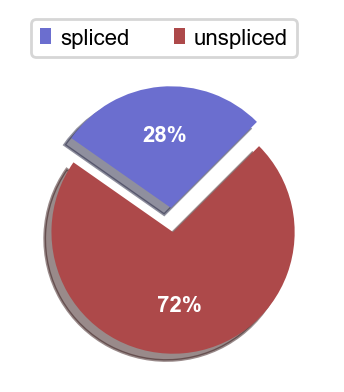

Filtered out 29133 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [9]:
scv.pl.proportions(adata_sub)
adata2 = scv.pp.filter_genes(adata_sub, min_shared_counts = 5, copy = True)
scv.pp.normalize_per_cell(adata2, enforce = True)
scv.pp.log1p(adata2)
adata2.layers['unspliced'] = adata2.layers['unspliced'].todense()
scv.pp.moments(adata2, n_pcs = 30, n_neighbors = 30)
scv.tl.recover_dynamics(adata2)
scv.tl.velocity(adata2, mode = 'dynamical')
scv.tl.velocity_graph(adata2)
adata2.obs['max_cosine_corr'] = adata2.uns['velocity_graph'].max(1).A.flatten()

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_dynamical_stream.png


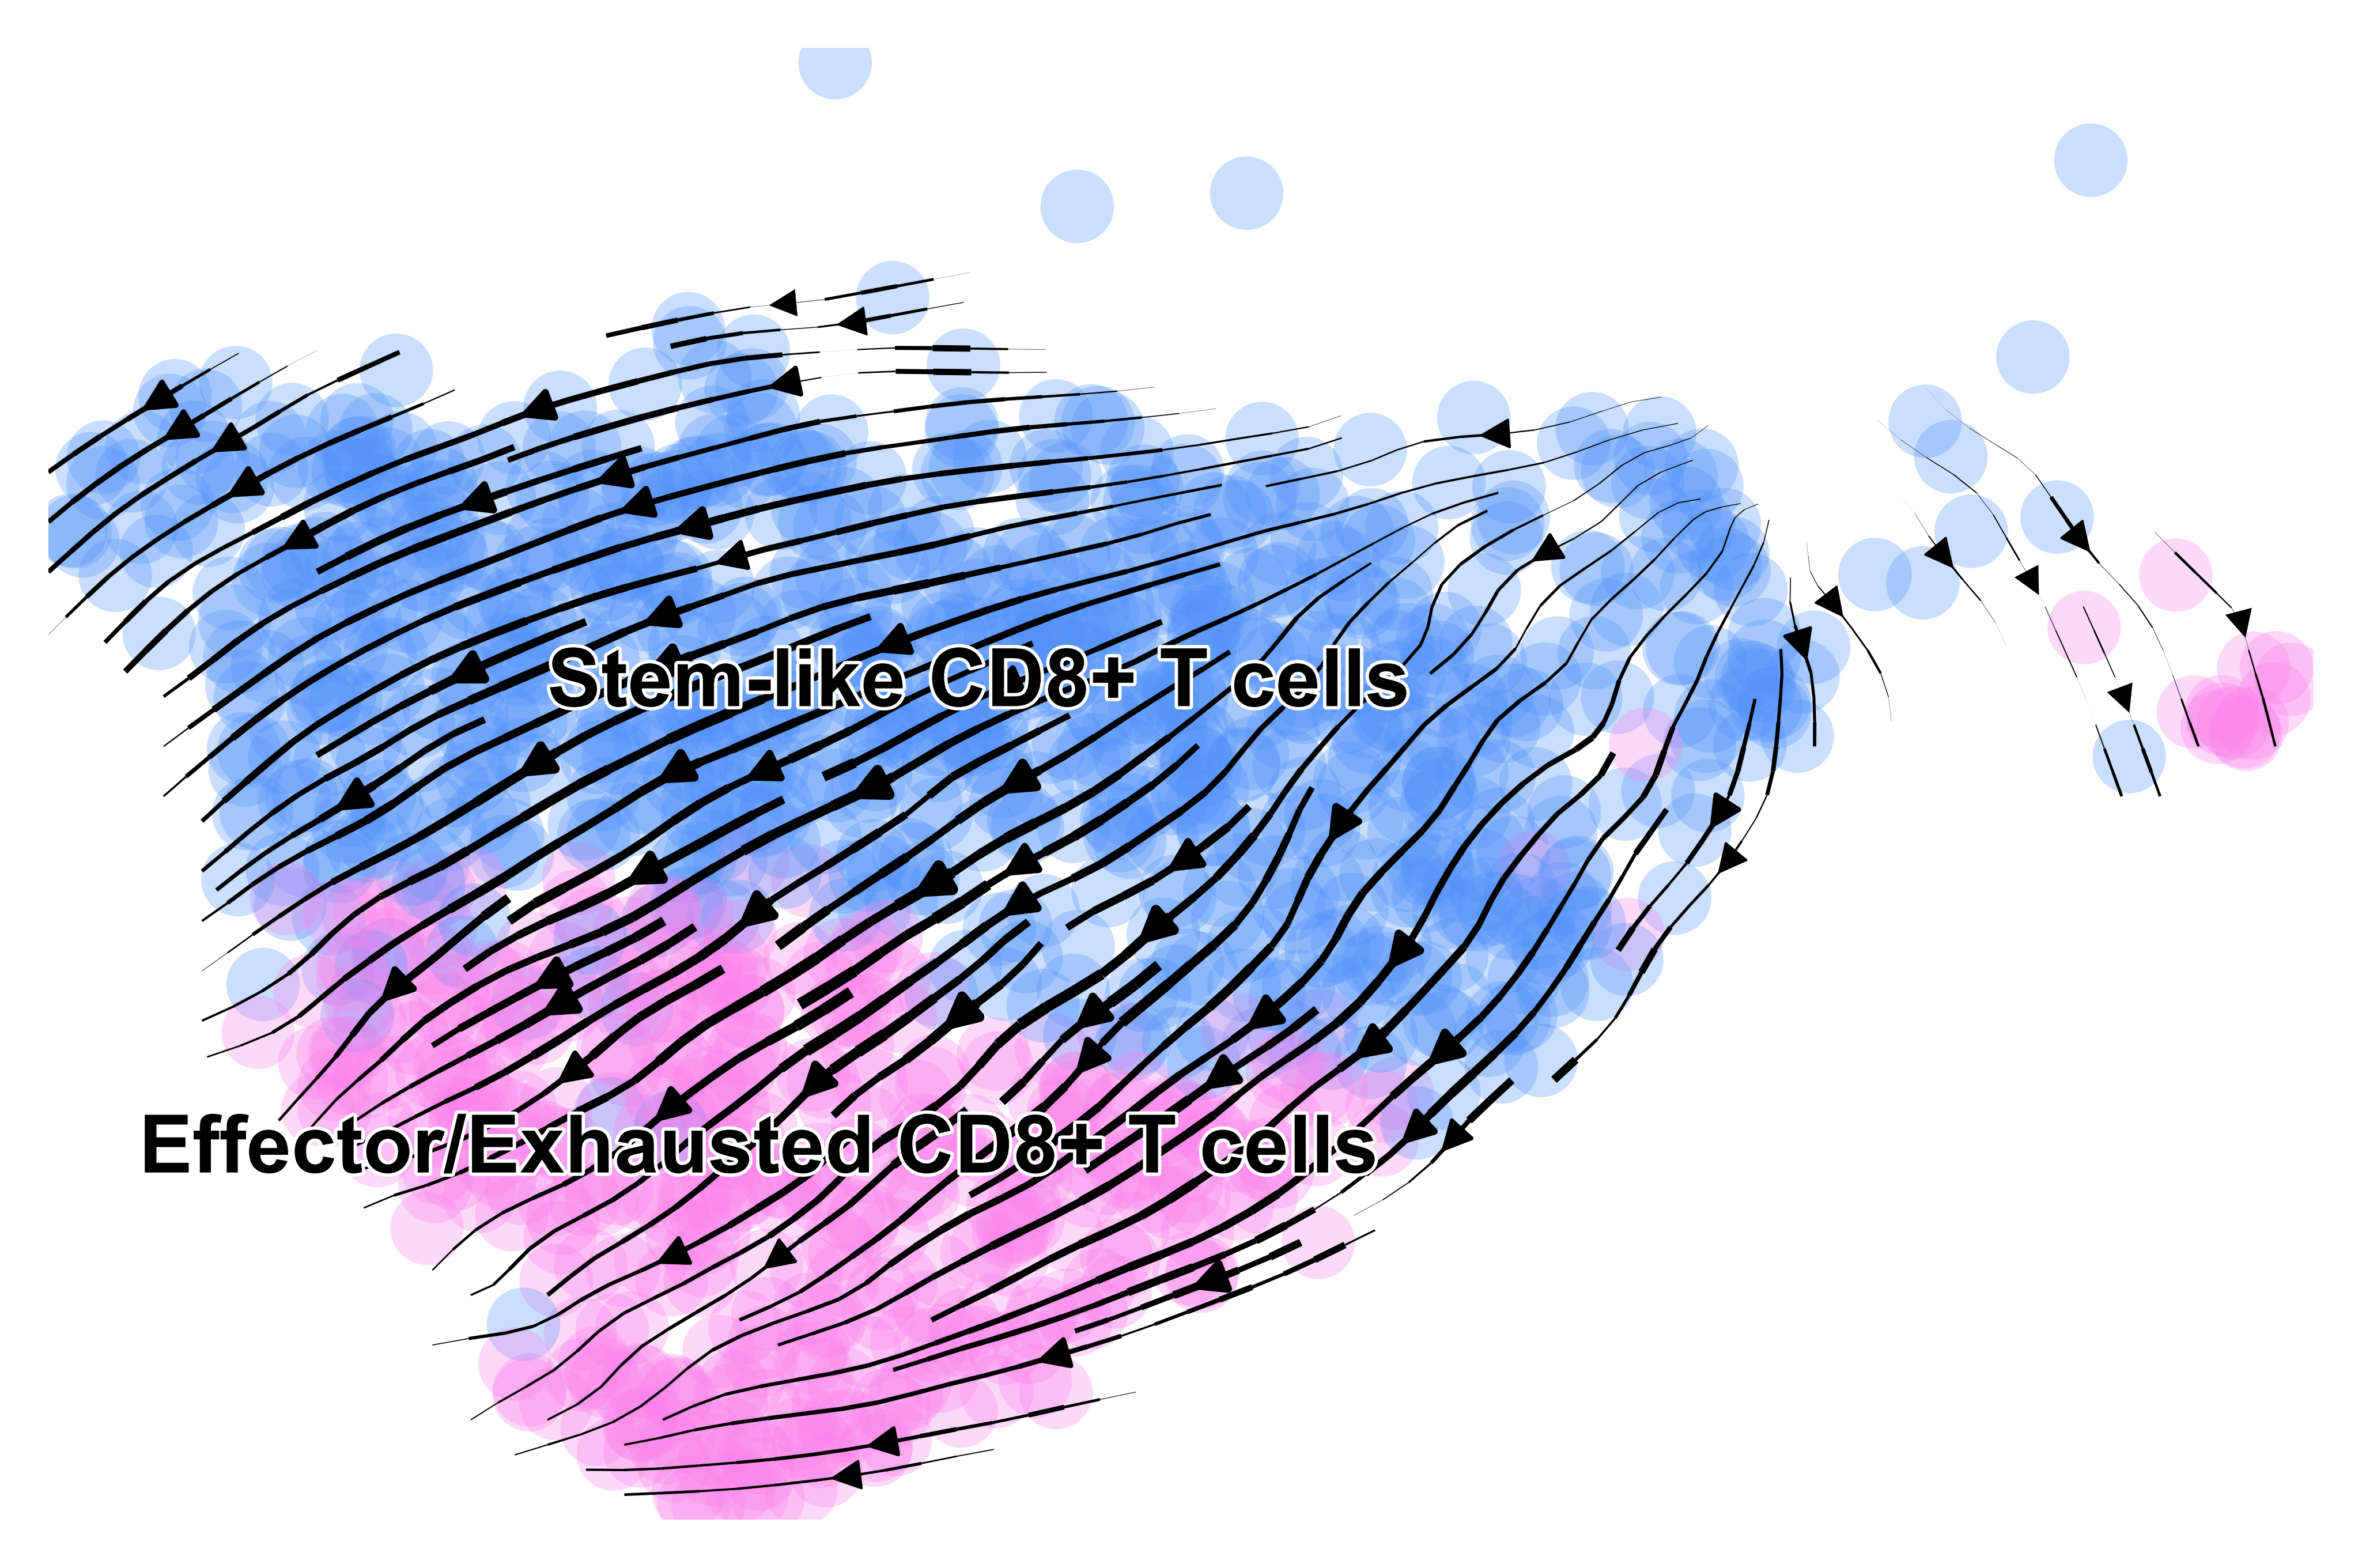

In [10]:
scv.pl.velocity_embedding_stream(adata2, basis='umap', color = 'x', title = '', dpi=420,
                                 palette = ['#fb82eb', '#5292fa'],
                                 save = 'dynamical_stream.pdf')

saving figure to file ./figures/scvelo_dynamical_arrow.pdf


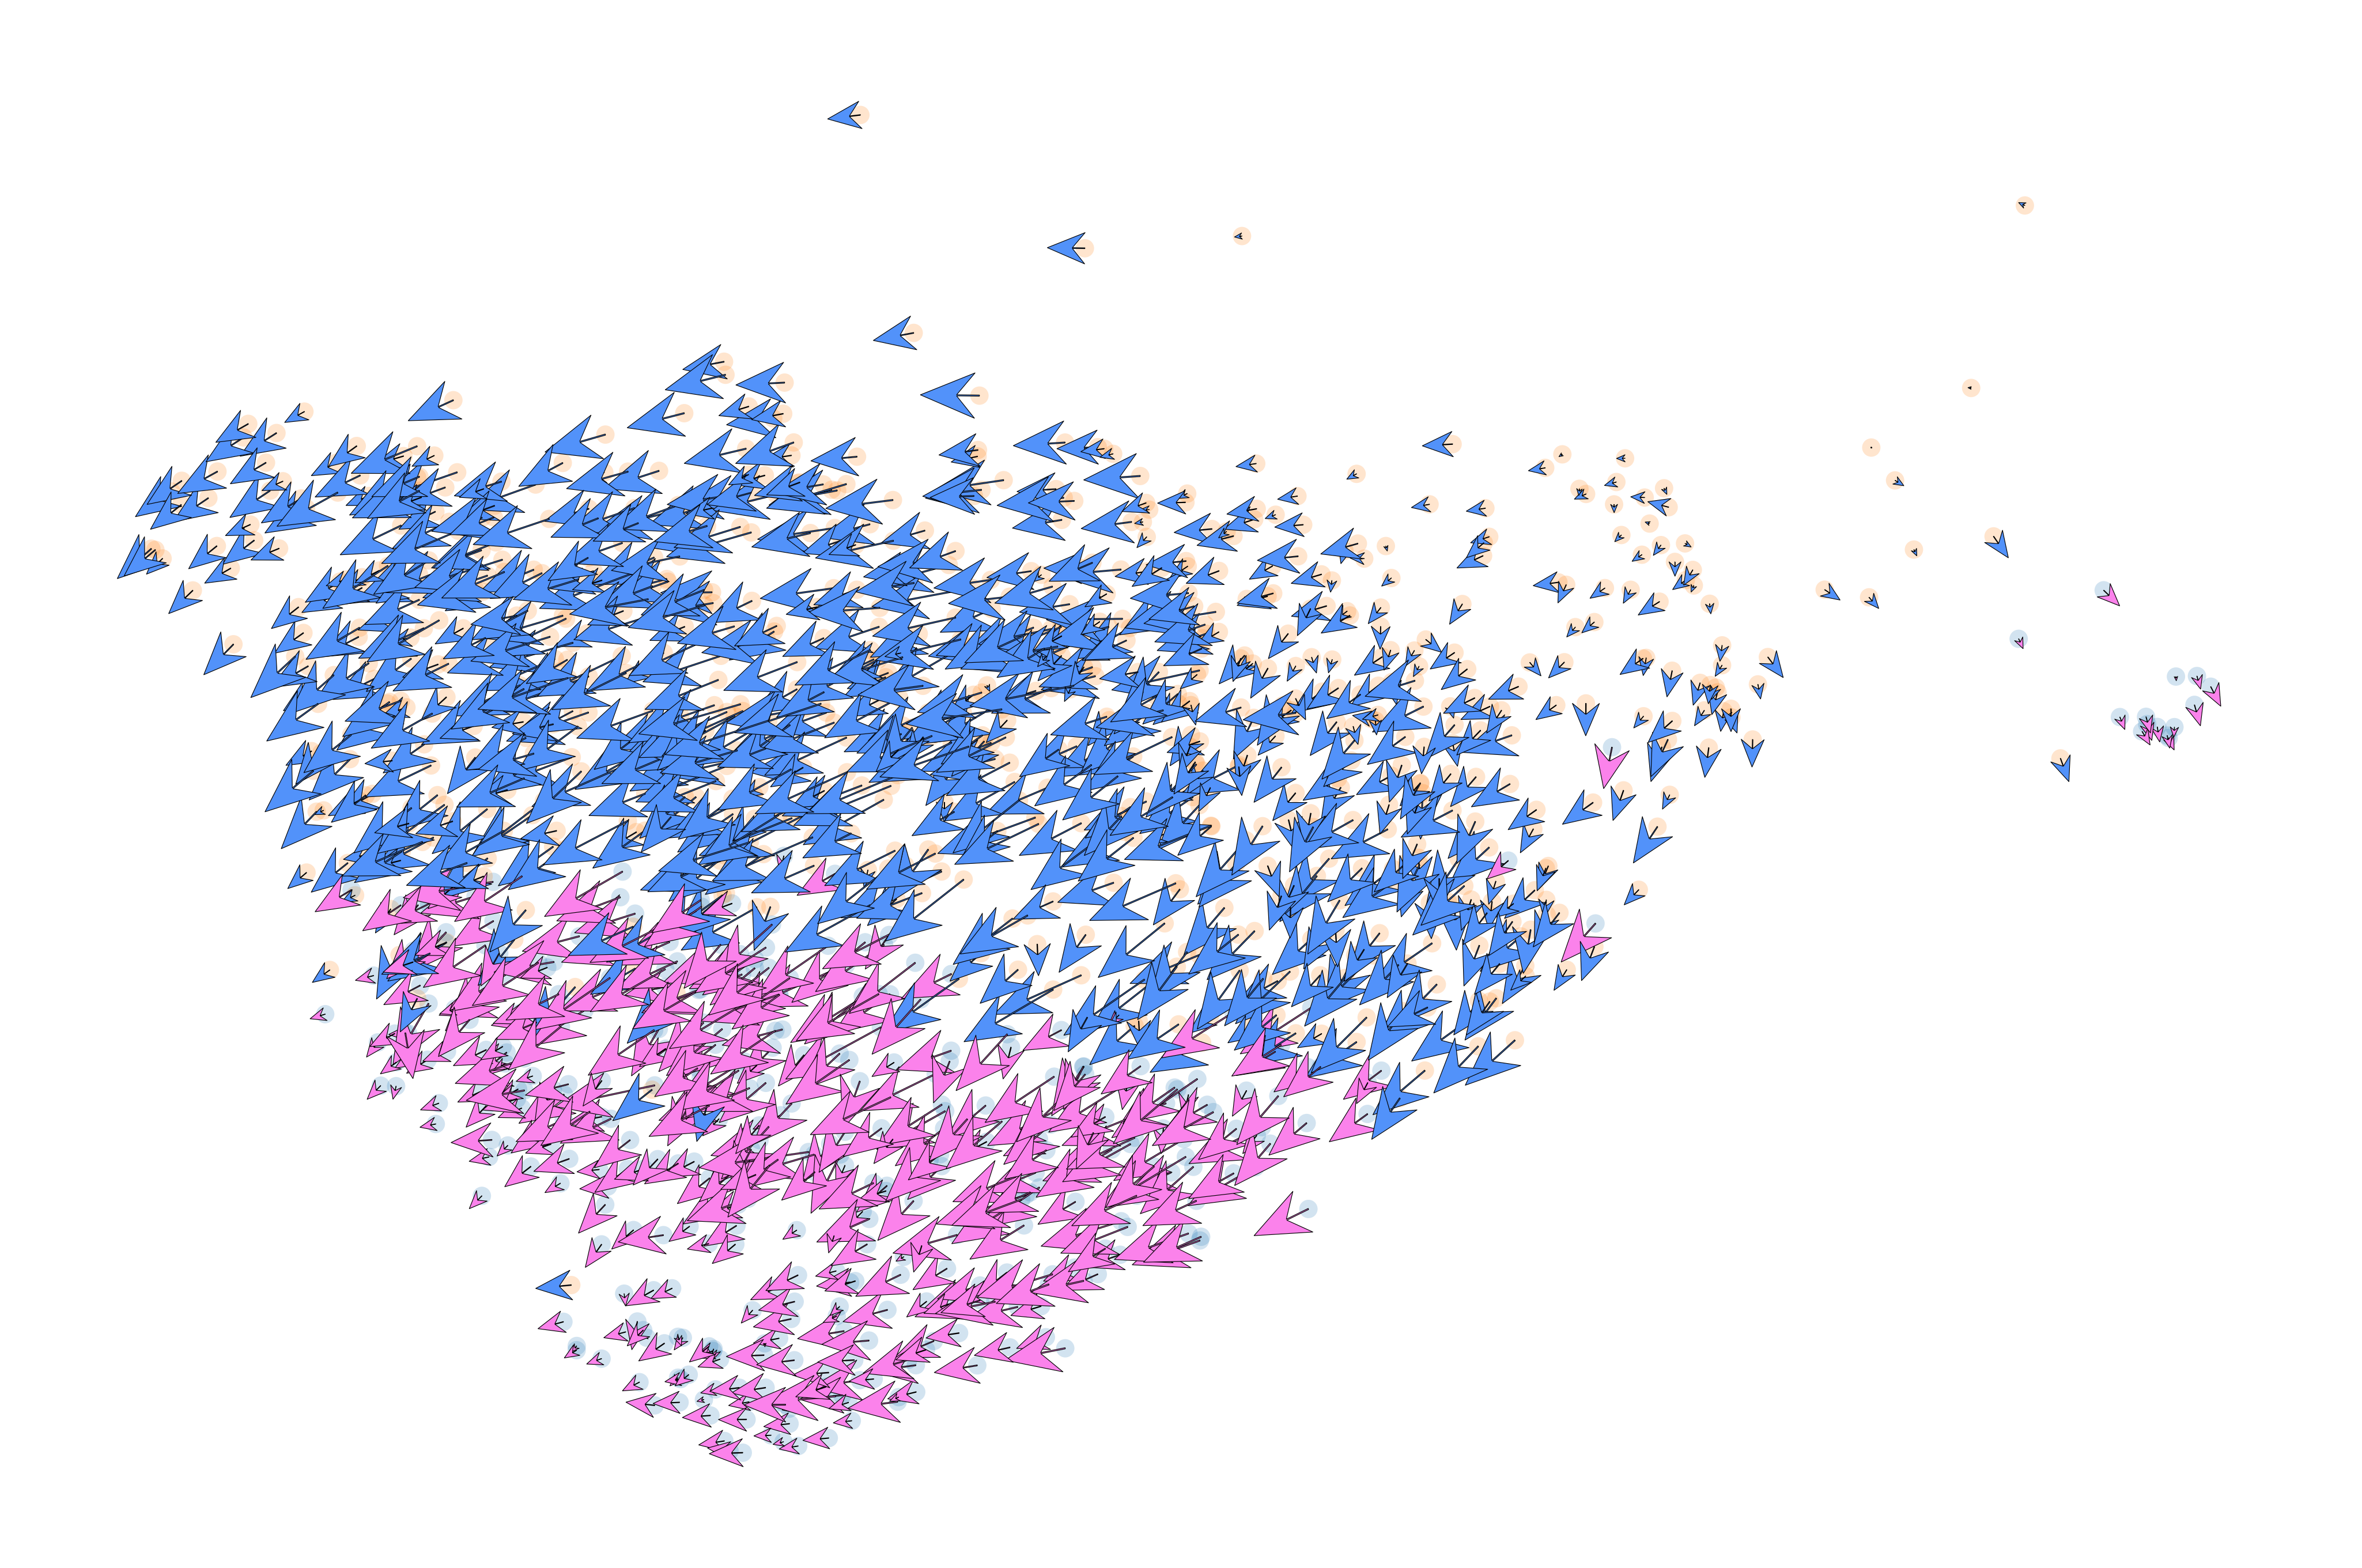

In [11]:
scv.pl.velocity_embedding(adata2, dpi=420, arrow_size=4, arrow_length=4, title = '',
                          palette = ['fb82eb', '#5292fa'],
                          color = 'x', save = 'dynamical_arrow.pdf')

computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_dynamical_latent_time.pdf


/Users/linglinhuang/miniconda3/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


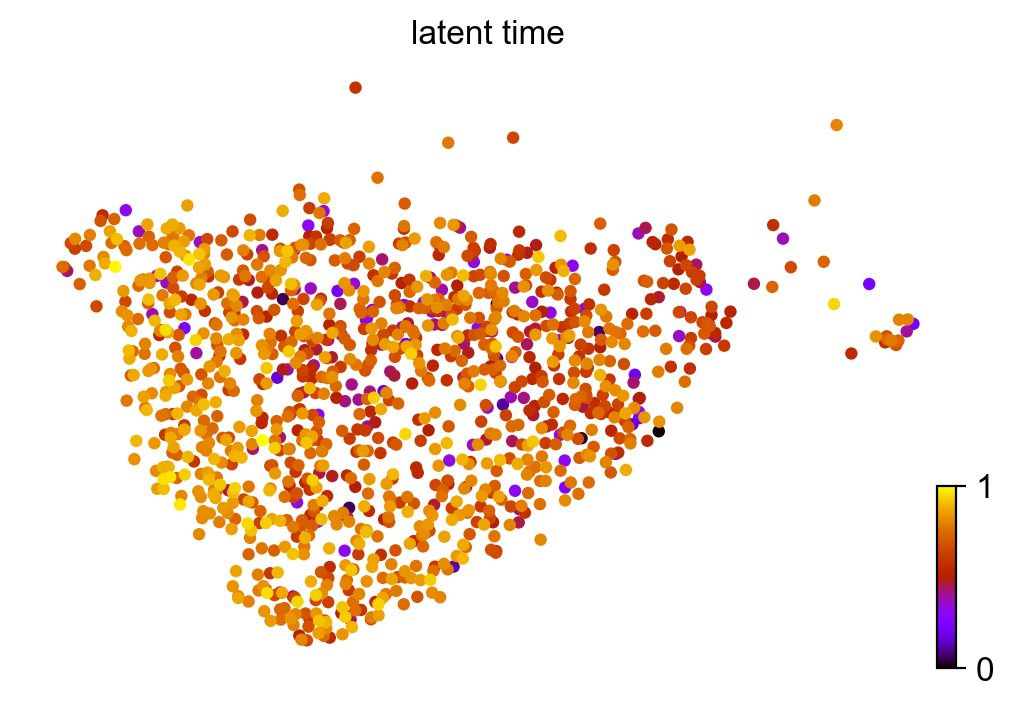

In [12]:
scv.tl.latent_time(adata2)
scv.pl.scatter(adata2, color='latent_time', color_map='gnuplot', size=80, save = 'dynamical_latent_time.pdf')